In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import neurokit2 as nk
import numpy as np
import json

# load data

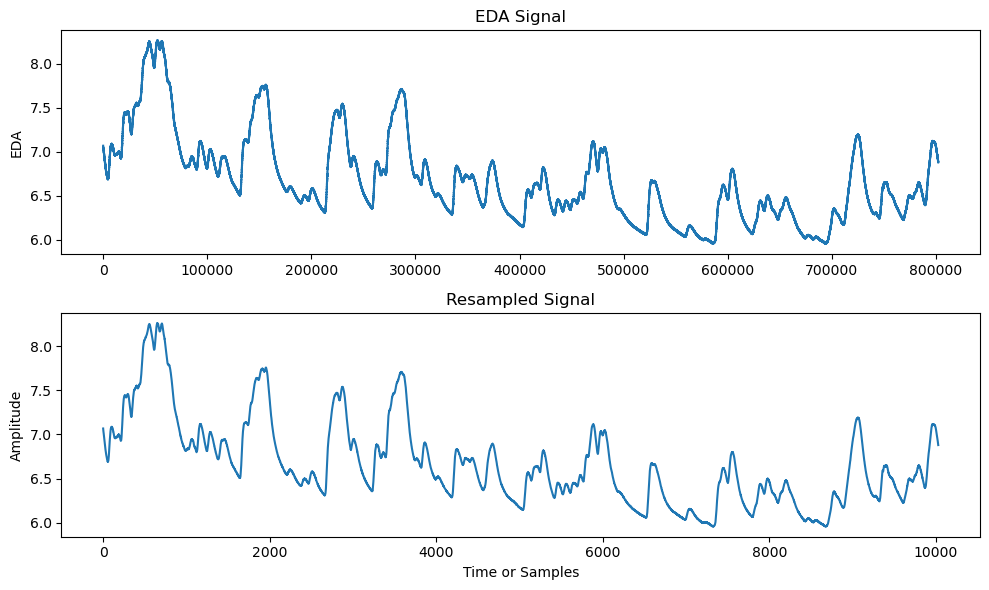

In [10]:
df = pd.read_csv('/Users/h/Documents/projects_local/sandbox/physiodata/sub-0081/ses-04/sub-0081_ses-04_task-cue_run-03-pain_recording-ppg-eda-trigger_physio.tsv', sep='\t')

source_samplingrate=2000
dest_samplingrate=25
resamp = nk.signal_resample(
            df['physio_eda'].to_numpy(),  method='interpolation', sampling_rate=source_samplingrate, desired_sampling_rate=dest_samplingrate)

df.head()
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)  # Share the x-axis
axs[0].plot(df['physio_eda'])
axs[0].set_title('EDA Signal')
axs[0].set_ylabel('EDA')

# Plot `resamp` on the second subplot
axs[1].plot(resamp)
axs[1].set_title('Resampled Signal')
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time or Samples')  
plt.tight_layout() 
plt.show()


In [13]:
from netneurotools import datasets as nntdata
# extract time series
from nilearn.maskers import NiftiMapsMasker,  NiftiLabelsMasker
from nilearn import datasets
fmri_fname = '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0081/ses-04/func/sub-0081_ses-04_task-social_acq-mb8_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confounds_fname = '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0081/ses-04/func/sub-0081_ses-04_task-social_acq-mb8_run-3_desc-confounds_timeseries.tsv'
# schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
masker = NiftiLabelsMasker(labels_img=schaefer['maps'], 
                           labels=schaefer['labels']
                        #    standardize=True, 
                        #    high_pass=128,
                        #    t_r=0.46
                           )
# %%
# subset confounds
confounds = pd.read_csv(confounds_fname,sep='\t')
filter_col = [col for col in confounds if col.startswith("motion")]
default_csf_24dof = [
    "csf",
    "trans_x",
    "trans_x_derivative1",
    "trans_x_power2",
    "trans_x_derivative1_power2",
    "trans_y",
    "trans_y_derivative1",
    "trans_y_derivative1_power2",
    "trans_y_power2",
    "trans_z",
    "trans_z_derivative1",
    "trans_z_derivative1_power2",
    "trans_z_power2",
    "rot_x",
    "rot_x_derivative1",
    "rot_x_derivative1_power2",
    "rot_x_power2",
    "rot_y",
    "rot_y_derivative1",
    "rot_y_derivative1_power2",
    "rot_y_power2",
    "rot_z",
    "rot_z_derivative1",
    "rot_z_derivative1_power2",
    "rot_z_power2",
]
filter_col.extend(default_csf_24dof)
dummy = pd.DataFrame(np.eye(len(confounds))).loc[:, 0:5]
dummy.rename(
    columns={
        0: "dummy_00",
        1: "dummy_01",
        2: "dummy_02",
        3: "dummy_03",
        4: "dummy_04",
        5: "dummy_05"
    },
    inplace=True,
)
subset_confounds = pd.concat([confounds[filter_col], dummy], axis=1)

print("grabbed all the confounds and fmri data")
subset_confounds.head()
time_series = masker.fit_transform(fmri_fname,
                                confounds=subset_confounds.fillna(subset_confounds.median()))

grabbed all the confounds and fmri data


/Users/h/miniconda3/envs/physio/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [14]:
first_roi = time_series.T[0]
TR=0.46
fmri_samplingrate = 1/0.46
# resamp
physio_tr = nk.signal_resample(
            df['physio_eda'].to_numpy(),  method='interpolation', sampling_rate=source_samplingrate, desired_sampling_rate=fmri_samplingrate)

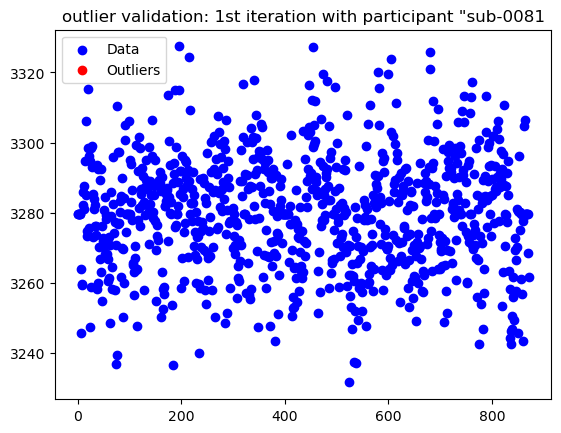

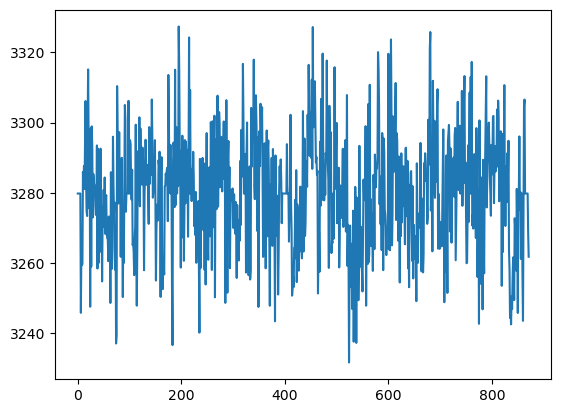

In [16]:
second_roi = time_series.T[1]

outlier_bool = nk.find_outliers(second_roi, exclude=3, side='both', method='sd')
import matplotlib.pyplot as plt

# Original data
x = list(range(len(second_roi)))
plt.scatter(x, second_roi, color='blue', label='Data')

column_values = second_roi
outlier_data = [column_values[i] if outlier else None for i, outlier in enumerate(outlier_bool)]
plt.scatter(x, outlier_data, color='red', label='Outliers')
plt.title('outlier validation: 1st iteration with participant "sub-0081')
plt.legend()
plt.show()

# mask boolean array
# first_roi_dropoutlier  = np.where(outlier_bool, first_roi, np.nan)
second_roi_dropoutlier = np.where(outlier_bool, np.nan, second_roi)
plt.plot(second_roi_dropoutlier)
plt.show()

## drop outlier

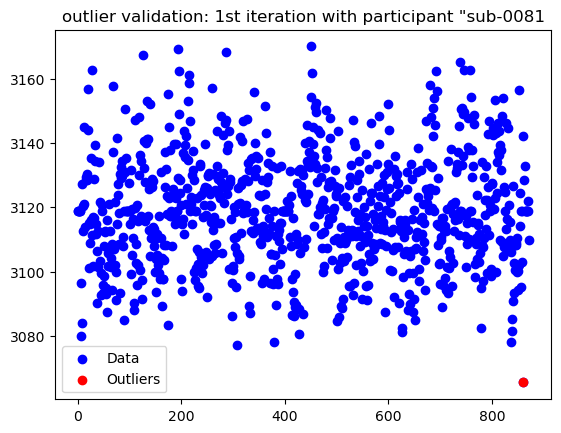

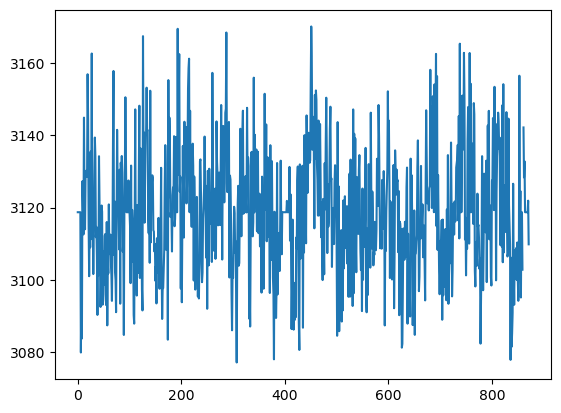

In [18]:

outlier_bool = nk.find_outliers(first_roi, exclude=3, side='both', method='sd')
import matplotlib.pyplot as plt

# Original data
x = list(range(len(first_roi)))
plt.scatter(x, first_roi, color='blue', label='Data')

column_values = first_roi
outlier_data = [column_values[i] if outlier else None for i, outlier in enumerate(outlier_bool)]
plt.scatter(x, outlier_data, color='red', label='Outliers')
plt.title('outlier validation: 1st iteration with participant "sub-0081')
plt.legend()
plt.show()

# mask boolean array
# first_roi_dropoutlier  = np.where(outlier_bool, first_roi, np.nan)
first_roi_dropoutlier = np.where(outlier_bool, np.nan, first_roi)
plt.plot(first_roi_dropoutlier)
plt.show()

## ground truth cross corelation sandbox

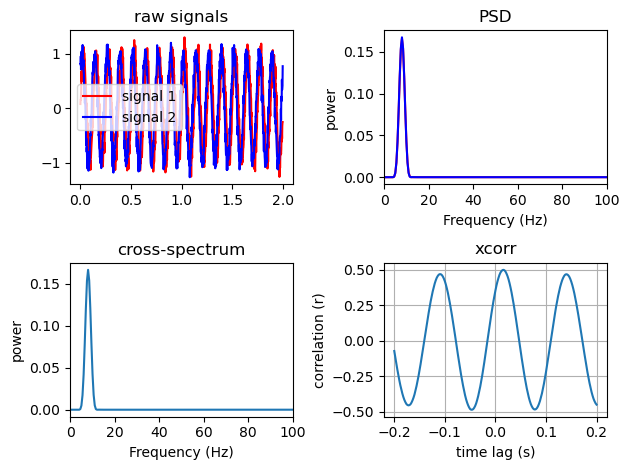

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd, correlate
from scipy.signal.windows import hann
# Generate signals
Fs = 500
tvec = np.arange(0, 2, 1/Fs)
data1 = np.sin(2 * np.pi * 8 * tvec) + 0.1 * np.random.randn(len(tvec))
data2 = np.sin(2 * np.pi * 8 * tvec + np.pi/4) + 0.1 * np.random.randn(len(tvec))

# Plot raw signals
plt.figure()
plt.subplot(221)
plt.plot(tvec, data1, 'r', tvec, data2, 'b')
plt.legend(['signal 1', 'signal 2'])
plt.title('raw signals')

# Compute and plot PSD
window = hann(250)
noverlap = 125
nfft = len(data1)

f, Pxx = welch(data1, Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(222)
plt.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
plt.xlim([0, 100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('PSD')

# Compute and plot cross-spectrum
f, Pxy = csd(data1, data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(223)
plt.plot(f, np.abs(Pxy))
plt.xlim([0, 100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('cross-spectrum')

# Compute and plot cross-correlation
maxlags = 100
acf = correlate(data1, data2, mode='full', method='auto')
acf /= len(data1)  # Normalizing
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

plt.subplot(224)
plt.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
plt.grid(True)
plt.xlabel('time lag (s)')
plt.ylabel('correlation (r)')
plt.title('xcorr')

# Show the figure
plt.tight_layout()
plt.show()

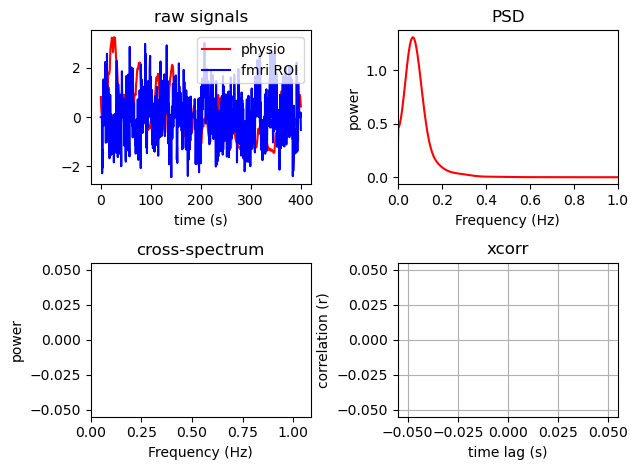

In [90]:
# modify this for physio and fmri _______________
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd, correlate
from scipy.signal.windows import hann
# Generate signals
Fs = 1/TR #1/TR
 
physio_standardized = (physio_tr - np.nanmean(physio_tr) )/ np.nanstd(physio_tr)
fmri_standardized = (first_roi_dropoutlier - np.nanmean(first_roi_dropoutlier)) / np.nanstd(first_roi_dropoutlier)
tvec = np.arange(0, len(physio_standardized) / Fs, 1/Fs)
data1 = physio_standardized
data2 = fmri_standardized

# Plot raw signals
plt.figure()
plt.subplot(221)
plt.plot(tvec, data1, 'r', tvec, data2, 'b')
plt.legend(['physio', f'fmri ROI'])
plt.xlabel('time (s)')
plt.title('raw signals')

# Compute and plot PSD
ws = int(Fs * 15)
window = hann(ws)
noverlap = ws // 2
nfft = len(tvec)

f, Pxx = welch(data1, Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(222)
plt.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
plt.xlim([0, 1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('PSD')

# Compute and plot cross-spectrum
f, Pxy = csd(data1, data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(223)
plt.plot(f, np.abs(Pxy))
plt.xlim([0, Fs/2]) # Nyquist frequency is the upper bound
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('cross-spectrum')

# Compute and plot cross-correlation
maxlags = int(Fs * 30)
acf = correlate(data1, data2, mode='full', method='auto')
# acf /= len(data1)  # Normalizing
norm_factor = np.sqrt(np.sum(data1**2) * np.sum(data2**2))
ccf = acf / norm_factor
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)
max_lags_index = np.where((lags >= -maxlags) & (lags <= maxlags))
ccf = ccf[max_lags_index]
lags = lags[max_lags_index]
convert_lags = lags;
plt.subplot(224)
plt.plot(convert_lags, ccf)
# plt.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], ccf[len(ccf)//2-maxlags:len(ccf)//2+maxlags+1])
plt.grid(True)
plt.xlabel('time lag (s)')
plt.ylabel('correlation (r)')
plt.title('xcorr')

# Show the figure
plt.tight_layout()
plt.show()


In [87]:
Pxy

array([-9.88092964e-02+0.00000000e+00j, -2.00115134e-01-9.53952185e-02j,
       -2.07556313e-01-1.90286095e-01j, -2.19797771e-01-2.84172609e-01j,
       -2.36602180e-01-3.76563343e-01j, -2.57644051e-01-4.66979673e-01j,
       -2.82516339e-01-5.54959837e-01j, -3.10738661e-01-6.40062826e-01j,
       -3.41766984e-01-7.21872070e-01j, -3.75004533e-01-7.99998879e-01j,
       -4.09813716e-01-8.74085588e-01j, -4.45528776e-01-9.43808396e-01j,
       -4.81468918e-01-1.00887984e+00j, -5.16951621e-01-1.06905092e+00j,
       -5.51305847e-01-1.12411276e+00j, -5.83884882e-01-1.17389792e+00j,
       -6.14078526e-01-1.21828122e+00j, -6.41324392e-01-1.25718013e+00j,
       -6.65118091e-01-1.29055468e+00j, -6.85022091e-01-1.31840694e+00j,
       -7.00673087e-01-1.34078004e+00j, -7.11787766e-01-1.35775675e+00j,
       -7.18166843e-01-1.36945760e+00j, -7.19697341e-01-1.37603866e+00j,
       -7.16353084e-01-1.37768888e+00j, -7.08193429e-01-1.37462717e+00j,
       -6.95360311e-01-1.36709910e+00j, -6.78073686

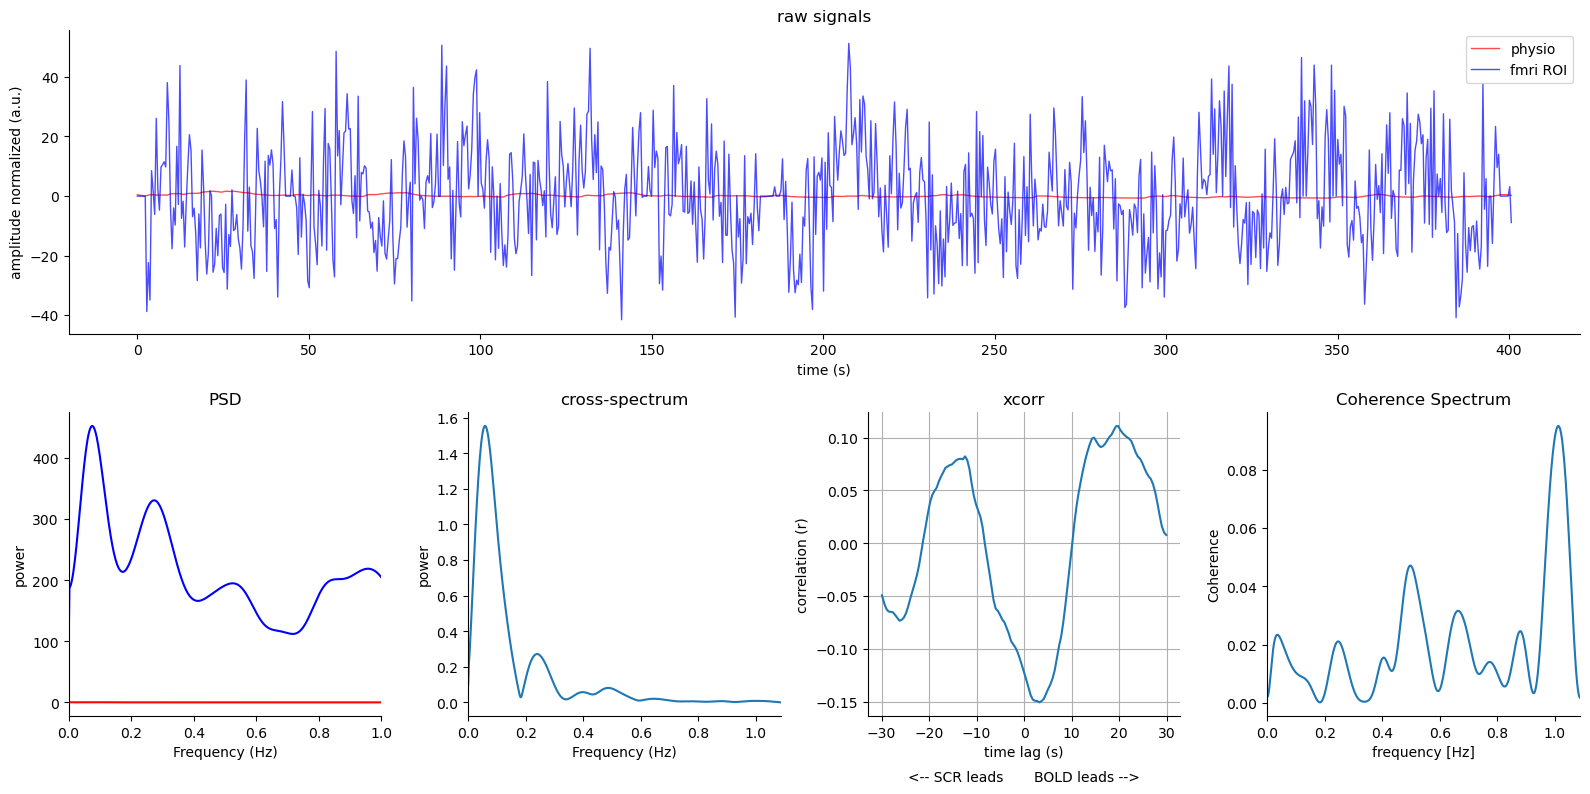

In [93]:
# modify this for physio and fmri _______________
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd, correlate, coherence
from scipy.signal.windows import hann
import matplotlib.gridspec as gridspec
import seaborn as sns
# Generate signals
TR=0.46
Fs = 1/TR #1/TR
# clean up data
physio_standardized = (physio_tr - np.nanmean(physio_tr))
#/ np.nanstd(physio_tr)
fmri_standardized = (first_roi_dropoutlier - np.nanmean(first_roi_dropoutlier))
#/np.nanstd(first_roi_dropoutlier)
tvec = np.arange(0, len(physio_standardized) / Fs, 1/Fs)
data1_centered = physio_standardized - np.nanmean(physio_standardized)
data2_centered = fmri_standardized - np.nanmean(fmri_standardized)#fmri_standardizednp.nan_to_num(np.mean(fmri_standardized))
# Calculate the mean of non-NaN values
# mean_data1 = np.nanmean(data1)
# mean_data2 = np.nanmean(data2)
from scipy.interpolate import interp1d
# Replace NaN values with the computed mean
# data1 = np.where(np.isnan(data1), mean_data1, data1)
# data2 = np.where(np.isnan(data2), mean_data2, data2)
def interpolate_data(data):
    time_points = np.arange(len(data))
    valid = ~np.isnan(data)  # Mask of valid (non-NaN) data points
    interp_func = interp1d(time_points[valid], data[valid], kind='linear', fill_value="extrapolate")
    return interp_func(time_points)

# Interpolate missing values
data1 = interpolate_data(data1_centered)
data2 = interpolate_data(data2_centered)





fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :]) # Wide subplot on row 1
ax2 = fig.add_subplot(gs[1, 0]) # Subplot 1 on row 2
ax3 = fig.add_subplot(gs[1, 1]) # Subplot 2 on row 2
ax4 = fig.add_subplot(gs[1, 2]) # Subplot 3 on row 2
ax5 = fig.add_subplot(gs[1, 3]) # Subplot 3 on row 2
# plt 1: Plot raw signals ______________________________
ax1.plot(tvec, data1, 'r', linewidth=1, alpha=0.7)
ax1.plot(tvec, data2, 'b', linewidth=1, alpha=0.7)
ax1.legend(['physio', f'fmri ROI'])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude normalized (a.u.)')
ax1.set_title('raw signals')

# plt 2: Compute and plot PSD ______________________________
ws = int(Fs * 15)
window = hann(ws)
noverlap = ws // 2
nfft = len(tvec)

f, Pxx = welch(data1, Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

ax2.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
ax2.set_xlim([0, 1])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('power')
ax2.set_title('PSD')

# plot 3: Compute and plot cross-spectrum
f, Pxy = csd(data1, data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

# plt.subplot(223)
ax3.plot(f, np.abs(Pxy))
ax3.set_xlim([0, Fs/2]) # Nyquist frequency is the upper bound
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('power')
ax3.set_title('cross-spectrum')

# plot4: Compute and plot cross-correlation
maxlags = int(Fs * 30)
acf = correlate(data1, data2, mode='full', method='direct')
# crossSD = abs(Pxy)**2/(Pxx*Pyy)
norm_factor = np.sqrt(np.sum(data1**2) * np.sum(data2**2))
acf_normalized = acf / norm_factor
# Calculate auto-correlations at lag 0
# auto_corr_data1 = np.sum(data1 ** 2)
# auto_corr_data2 = np.sum(data2 ** 2)

# Normalize cross-correlation
# acf_normalized = acf / np.sqrt(auto_corr_data1 * auto_corr_data2)

# acf /= len(data1)  # Normalizing
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

# plt.subplot(224)
ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1])

# ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
ax4.grid(True)
ax4.set_xlabel('time lag (s)')
ax4.set_ylabel('correlation (r)')
ax4.set_title('xcorr')
ax4.text(0.5, -0.2, '<-- SCR leads       BOLD leads -->', ha='center', va='center', transform=ax4.transAxes)


# plot 5

f_coh, Cxy = coherence(data1, data2, Fs, window=hann(ws), noverlap=noverlap, nfft=nfft)
ax5.plot(f_coh, Cxy)
ax5.set_xlim([0, Fs/2])  # Limit to Nyquist frequency

ax5.set_xlabel('frequency [Hz]')
ax5.set_ylabel('Coherence')
ax5.set_title('Coherence Spectrum')
# Show the figure
plt.tight_layout()
sns.despine()
plt.show()


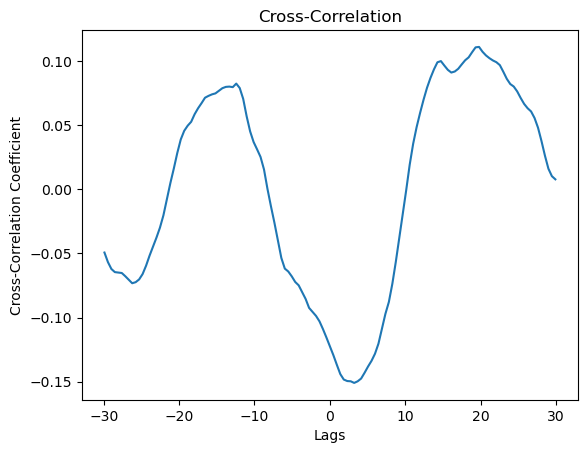

0.11108361389078682 43


In [74]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Assuming data1 and data2 are your data sequences

# Calculate the cross-correlation and lags
maxlags = int(Fs * 30)
ccf = correlate(data1 - np.mean(data1), data2 - np.mean(data2), mode='full', method='auto')
lags = np.arange(-len(data1) + 1, len(data2))

# Normalize the cross-correlation
norm_factor = np.sqrt(np.sum((data1 - np.mean(data1))**2) * np.sum((data2 - np.mean(data2))**2))
ccf /= norm_factor

# Limit the lags and cross-correlation to -max_lags to max_lags
max_lags_index = np.where((lags >= -maxlags) & (lags <= maxlags))
ccf = ccf[max_lags_index]
lags = lags[max_lags_index]
convert_lags = lags*(1./Fs); #convert samples to time

# Plot the cross-correlation function
plt.figure()
plt.plot(convert_lags, ccf)
plt.xlabel('Lags')
plt.ylabel('Cross-Correlation Coefficient')
plt.title('Cross-Correlation')
plt.show()

acf_sliced = ccf[len(ccf)//2-maxlags:len(ccf)//2+maxlags+1]
lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]
max_acf_value = np.max(acf_sliced)
max_acf_index = np.argmax(acf_sliced)
max_lag_time = lags_sliced[max_acf_index]
print(max_acf_value, max_lag_time)

In [47]:
acf = correlate(data1, data2,mode='full', method='direct')
lags = signal.correlation_lags(data1.size, data2.size, mode="full")

## Find max value of Xcorr

In [ ]:
len(lags)//2+maxlags+1

131

In [ ]:
# Slicing acf and lags for the plot range
acf_sliced = acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1]
lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]

# Find the maximum correlation value and corresponding time lag
max_acf_value = np.max(acf_sliced)
max_acf_index = np.argmax(acf_sliced)
max_lag_time = lags_sliced[max_acf_index]

print(f"Maximum Correlation Value: {max_acf_value}, At Time Lag: {max_lag_time} seconds")


Maximum Correlation Value: 0.24995734126669544, At Time Lag: 14.26 seconds


# TODO:
* run this for each ROI
* save the max corr and lag values in a pandas dataframe
* extract metadata sub/ses/run
* later, plot this in the brain for every parcel

<!-- Another way to calculate coherence spectrum
abs(Pxy) ** 2 / (Pxx*Pxy) -->

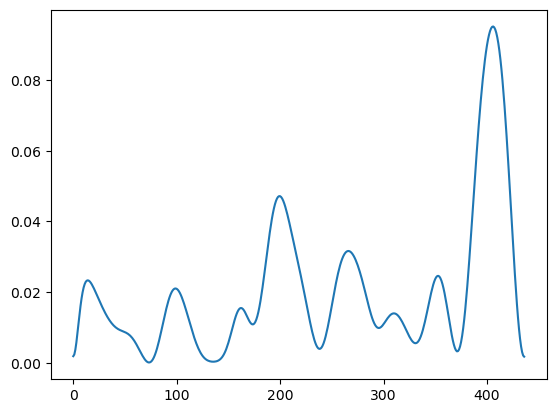

In [36]:
crossSD = abs(Pxy)**2/(Pxx*Pyy)
# ax5.plot(f_coh, crossSD)
plt.plot( crossSD)
# plt.xlim([0, Fs/2])
plt.show()

In [ ]:
time_series.shape

(872, 400)

# Suggestions from Matt
* deconvolve fMRI signal
* snip out xcorr value for each parcel
* plot average across participants